# Project Proposal:
## Predicting if a Business is Fraudulent using KNN Classification

### Group 28 Members: Michael Ly, Avery Ma and Veer Arora

Introduction:

* Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal
* Clearly state the question you will try to answer with your project
* Identify and describe the dataset that will be used to answer the question

Preliminary exploratory data analysis:
* Demonstrate that the dataset can be read from the web into R 
* Clean and wrangle your data into a tidy format
* Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 
* Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.

Methods:

* Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?
* Describe at least one way that you will visualize the results

Expected outcomes and significance:

* What do you expect to find?
* What impact could such findings have?
* What future questions could this lead to?
       

# Introduction: Fraudulent or Non-Fraudlent?


Given a data set of characteristics of firms of different sectors, historical mistatement scores, and different risk scores would we be able to create a K - Nearest Neighbor classification model that can accurately identify fraudulent firms? And will it be reliable and accurate enough for us to classify whether a firm is fraudulent or working in the best interest of its stakeholders?

Our data set examines the present and historical risk factors and financial discrepancy scores for the determining the audit risk score and concludes whether firm is classified under Risk (1) or No Risk (0).

According to the original description of the dataset, our data set consists of samples of firms across 14 different sectors categorized by Sector ID from 1 to 14.

The sector types in the data and the counts of firms are listed respectively as Irrigation (114), Public Health (77), Buildings and Roads (82), Forest (70), Corporate (47), Animal Husbandry (95), Communication (1), Electrical (4), Land (5), Science and Technology (3), Tourism (1), Fisheries (41), Industries (37), Agriculture (200).

Our data set is drawn from the UCI Machine Learning Repository, with its origins from Hooda, Nishtha, Seema Bawa, and Prashant Singh Rana. 'Fraudulent Firm Classification: A Case Study of an External Audit.' Applied Artificial Intelligence 32.1 (2018): 48-64. https://archive.ics.uci.edu/ml/datasets/Audit+Data

There are many different variables described in the original audit risk dataset such as analysis scores completed by the original authors that we have decided to remove because they have not been defined.

The original description of the dataset reports that after an in-depth interview with auditors, important risk factors have been evalutated and probability of existence of these risk factors have been calculated using their present and past records.

We have decided to include the variables listed to investigate as possible predictors for our model.

* Sector Score: Historical risk score value of the target-unit
* Location ID: Unique ID of the city/province.
* Para A value: Discrepancy found in the planned-expenditure of inspection
* Para B value: Discrepancy found in the unplanned-expenditure of inspection
* Numbers: Historical discrepancy score.
* Total: Total amount of discrepancy found in other reports Rs (PARA_A + PARA_B).
* Money Value: Amount of money involved in misstatements in the past audits.
* District Loss: Score based on amount of loss suffered by the district
* History: Average historical loss suffered by firm in the last 10 years.
* Inherent Risk: The risk posed by an error or omission in a financial statement due to a factor other than a failure of internal control.
* Control Risk: The chance of a material misstatement in a company’s financial statements because there aren’t any relevant internal controls to mitigate a particular risk or the internal controls in place malfunctioned.
* Detection Risk: The chance that an auditor will fail to find material misstatements that exist in an entity's financial statements.
* Audit Risk: The risk that the auditor expresses an inappropriate audit opinion when the financial statements are materially misstated
* Risk: Classifies whether a firm is considered Risk (1) or No Risk (2)

In [4]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [128]:
audit_risk_data <- read_csv("data/audit_risk.csv")
audit_risk_data <- mutate(audit_risk_data, Risk = as_factor(Risk))

audit_split <- initial_split(audit_risk_data, prop = 0.75, strata = Risk)
audit_training <- training(audit_split)
audit_testing <- testing(audit_split)

New names:
• `Score_B` -> `Score_B...7`
• `Score_B` -> `Score_B...11`
Rows: 776 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): LOCATION_ID
dbl (26): Sector_score, PARA_A, Score_A, Risk_A, PARA_B, Score_B...7, Risk_B...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


We will be working with Risk as our factor so we convert it accordingly before we split our data set.

We split our data into training and testing data, with 75% of the dataset representing the training data and the remaining 25% as the testing data. We then filter out our variables that have been defined to use to explore as possible predictors.

In [129]:
num_obs <- nrow(audit_training)
audit_training |> 
    group_by(Risk) |> 
    summarize(
        count = n(),
        percentage = n()/num_obs * 100)

Risk,count,percentage
<fct>,<int>,<dbl>
0,353,60.75731
1,228,39.24269


We then examine the number and percentage between the different levels of our factor within our training data set to see if each class is reasonably represented.

In [132]:
audit_training_select <- audit_training |> 
    select(Sector_score,LOCATION_ID,PARA_A,PARA_B,TOTAL,numbers, Money_Value, District_Loss,History, Inherent_Risk, CONTROL_RISK, Detection_Risk, Audit_Risk, Risk) 
audit_training_select

Sector_score,LOCATION_ID,PARA_A,PARA_B,TOTAL,numbers,Money_Value,District_Loss,History,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3.89,6,0.00,4.83,4.83,5,0.94,2,0,2.554,0.4,0.5,0.5108,0
3.89,6,0.51,0.23,0.74,5,0.00,2,0,1.548,0.4,0.5,0.3096,0
3.89,6,0.00,0.08,0.08,5,0.00,2,0,1.416,0.4,0.5,0.2832,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55.57,2,0.00,0.00,0.00,5,0.00,6,0,2.200,1.2,0.5,1.3200,1
55.57,2,1.06,0.63,1.69,5,0.90,6,0,2.930,1.2,0.5,1.7580,1
55.57,13,1.06,1.60,2.66,5,16.09,2,0,12.118,0.4,0.5,2.4236,1


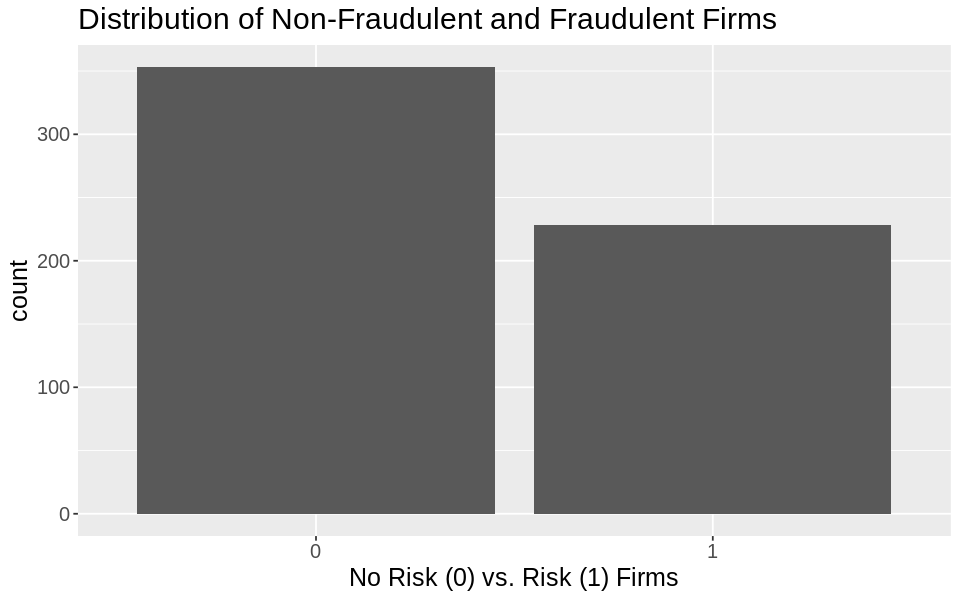

In [121]:
options(repr.plot.width = 8, repr.plot.height = 5)


numbers_plot <- audit_training_select |>
ggplot(aes(x= Risk)) +
geom_bar() + 
    xlab("No Risk (0) vs. Risk (1) Firms") +
    labs() +
    ggtitle("Distribution of Non-Fraudulent and Fraudulent Firms")+
    theme(text = element_text(size = 15))

numbers_plot

We look at the distribution of our two classes of No Risk and Risk firms to see if there is a dramatic difference between the number of them in our training data set. Based on this difference it does not seem to be significant enough to

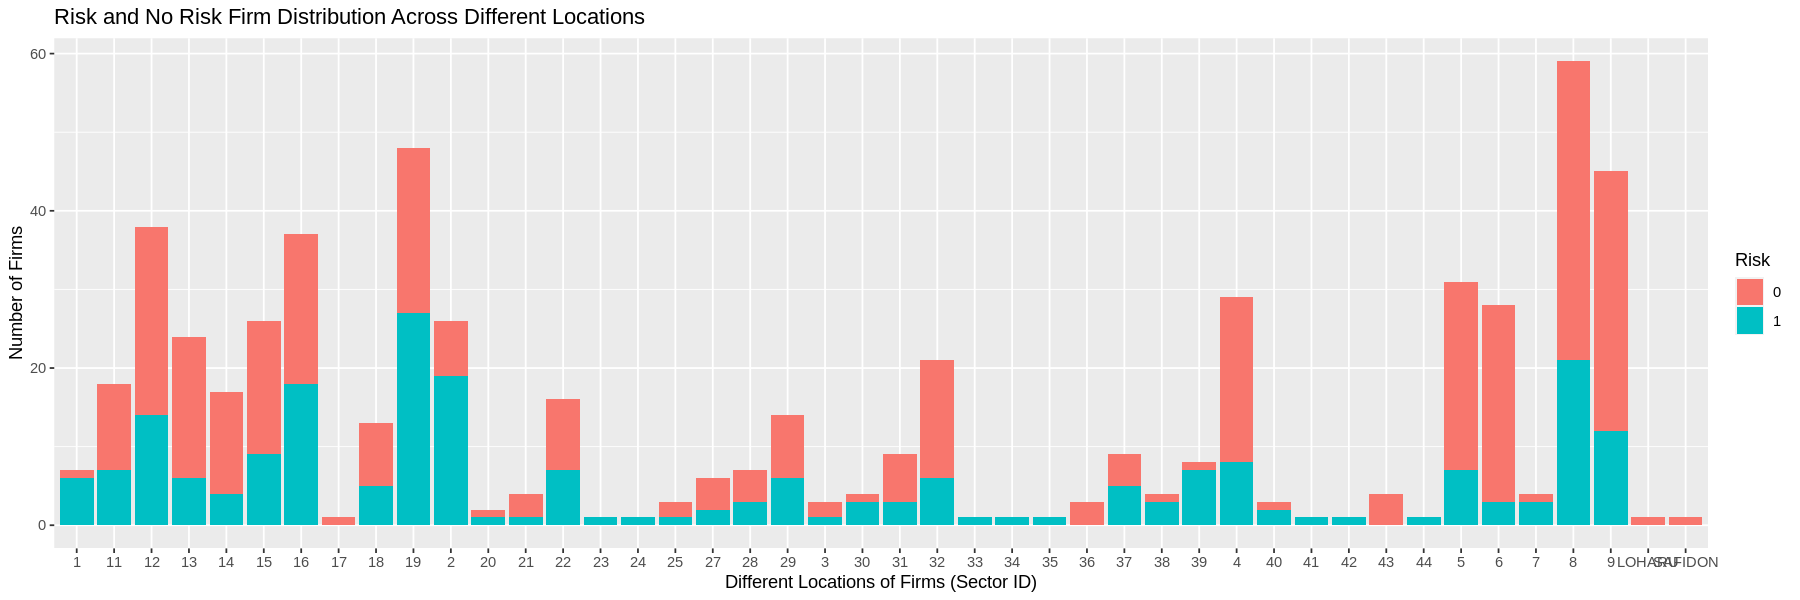

In [118]:
options(repr.plot.width = 15, repr.plot.height = 5)
ggplot(audit_training_select, aes(x= LOCATION_ID, fill = Risk)) +
    geom_bar() + 
    xlab("Different Locations of Firms (Sector ID)") +
    ylab("Number of Firms") +
    ggtitle("Risk and No Risk Firm Distribution Across Different Locations")

Macro Scope

Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”


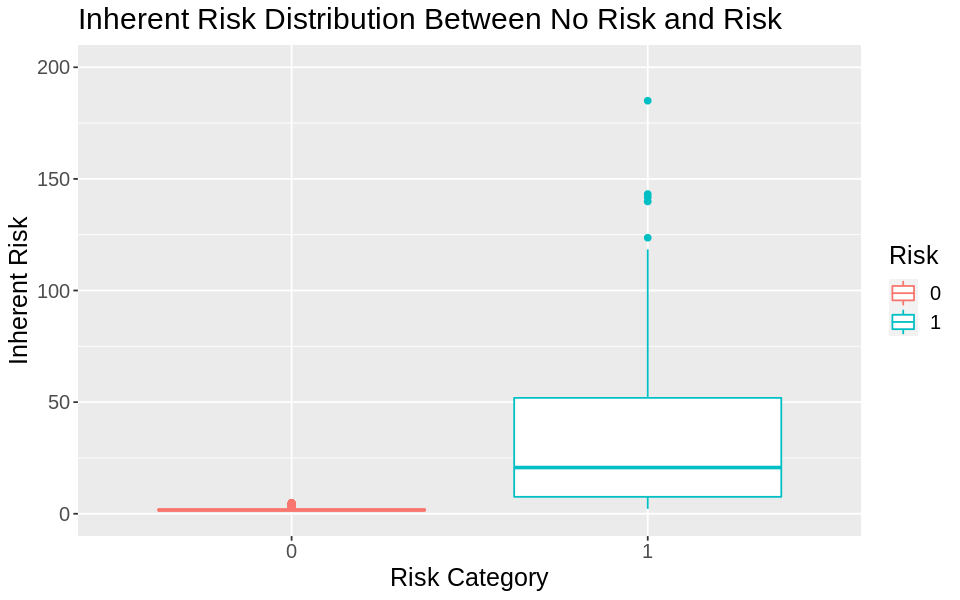

In [15]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(audit_training_select, aes(x = Risk, y=Inherent_Risk, color = Risk)) +
  geom_boxplot() +
  ylim(c(0, 200)) +
  labs(x = "Risk Category", y = "Inherent Risk") +
  ggtitle("Inherent Risk Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))


Warning message:
“Removed 4 rows containing non-finite values (stat_boxplot).”


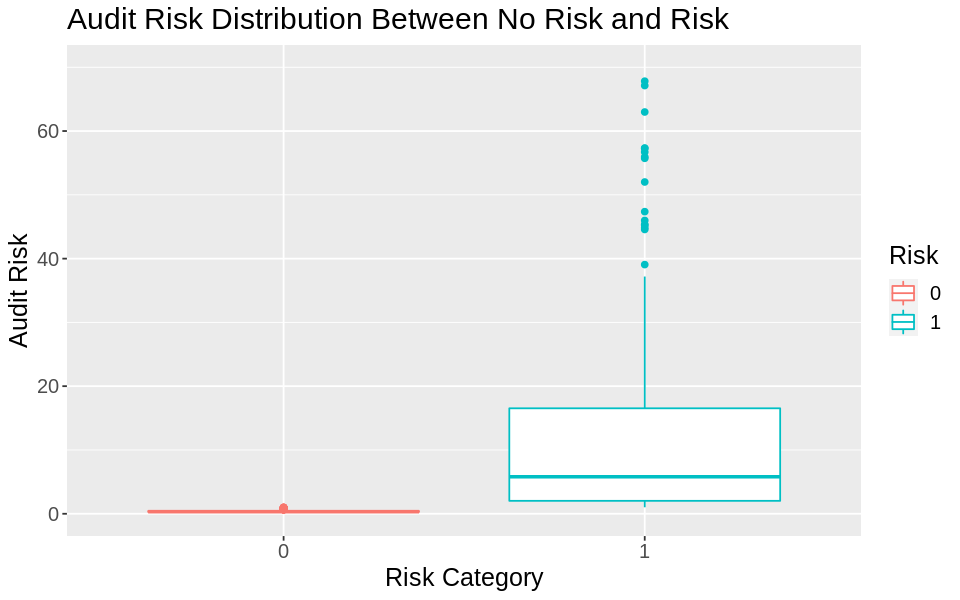

In [16]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(audit_training_select, aes(x = Risk, y=Audit_Risk, color = Risk)) +
  geom_boxplot() +
  ylim(c(0, 70)) +
  labs(x = "Risk Category", y = "Audit Risk") +
  ggtitle("Audit Risk Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))

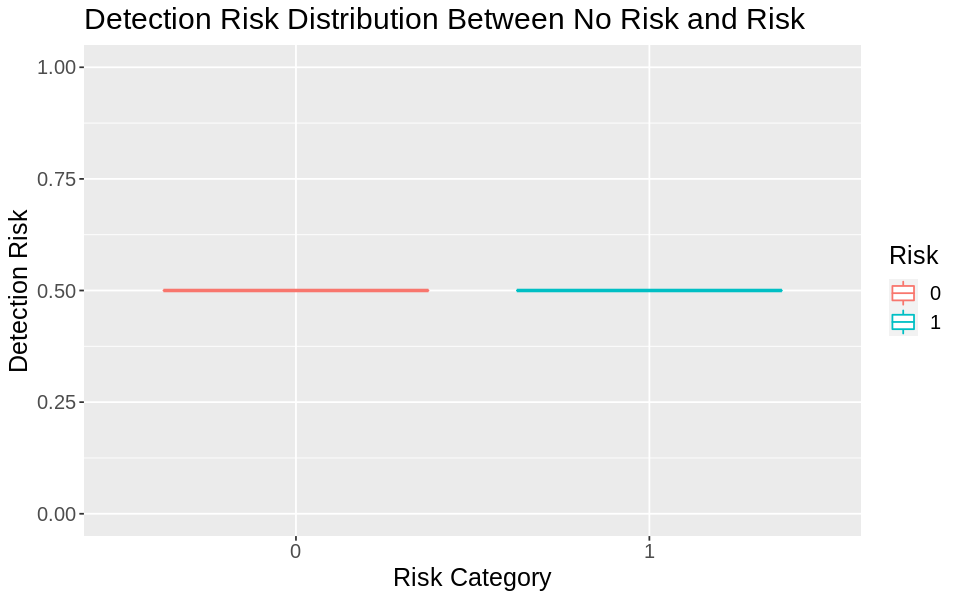

In [24]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(audit_training_select, aes(x = Risk, y=Detection_Risk, color = Risk)) +
  geom_boxplot() +
  ylim(c(0, 1)) +
  labs(x = "Risk Category", y = "Detection Risk") +
  ggtitle("Detection Risk Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))

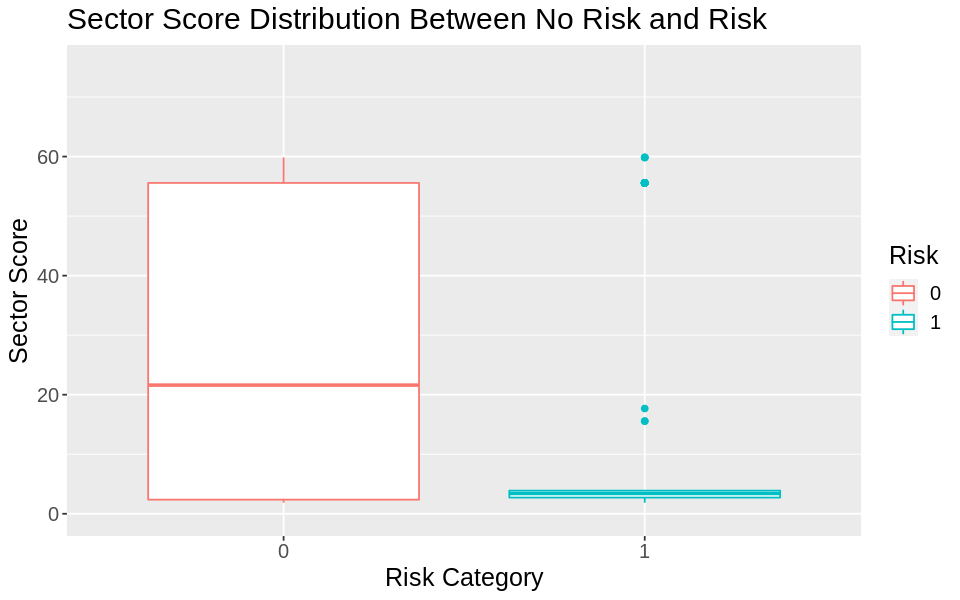

In [28]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(audit_training_select, aes(x = Risk, y = Sector_score, color = Risk)) +
  geom_boxplot() +
  ylim(c(0, 75)) +
  labs(x = "Risk Category", y = "Sector Score") +
  ggtitle("Sector Score Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))

Warning message:
“Removed 8 rows containing non-finite values (stat_boxplot).”


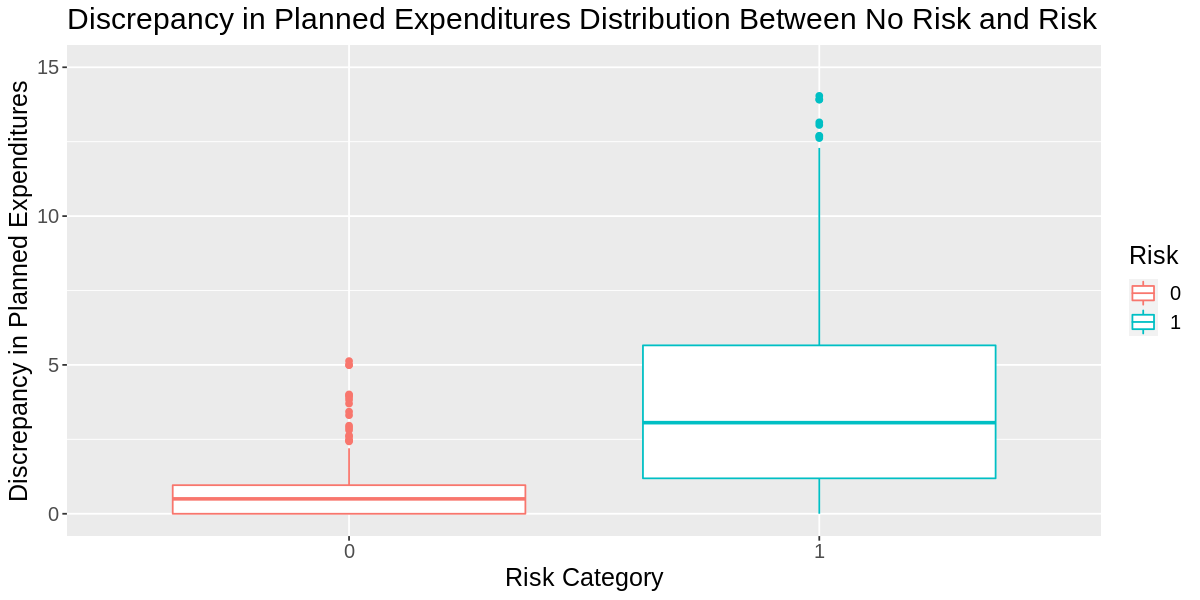

In [36]:
options(repr.plot.width = 10, repr.plot.height = 5)
ggplot(audit_training_select, aes(x = Risk, y = PARA_A, color = Risk)) +
  geom_boxplot() +
  ylim(c(0, 15)) +
  labs(x = "Risk Category", y = "Discrepancy in Planned Expenditures") +
  ggtitle("Discrepancy in Planned Expenditures Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))

Warning message:
“Removed 102 rows containing non-finite values (stat_boxplot).”


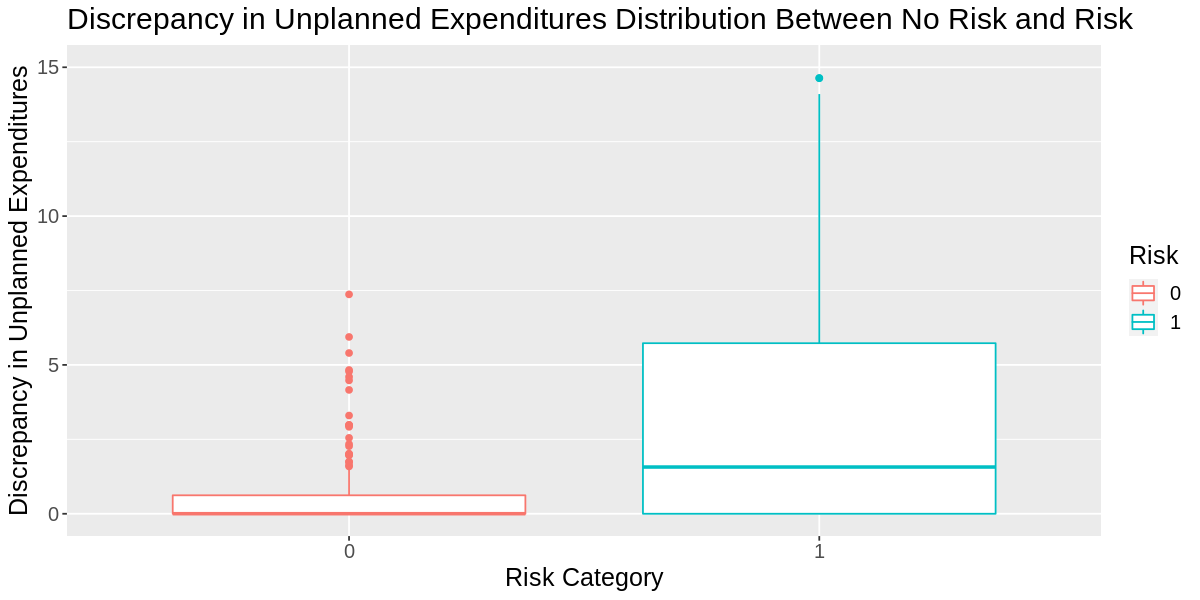

In [37]:
options(repr.plot.width = 10, repr.plot.height = 5)
ggplot(audit_training_select, aes(x = Risk, y = PARA_B, color = Risk)) +
  geom_boxplot() +
  ylim(c(0, 15)) +
  labs(x = "Risk Category", y = "Discrepancy in Unplanned Expenditures") +
  ggtitle("Discrepancy in Unplanned Expenditures Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))

Warning message:
“Removed 31 rows containing non-finite values (stat_boxplot).”


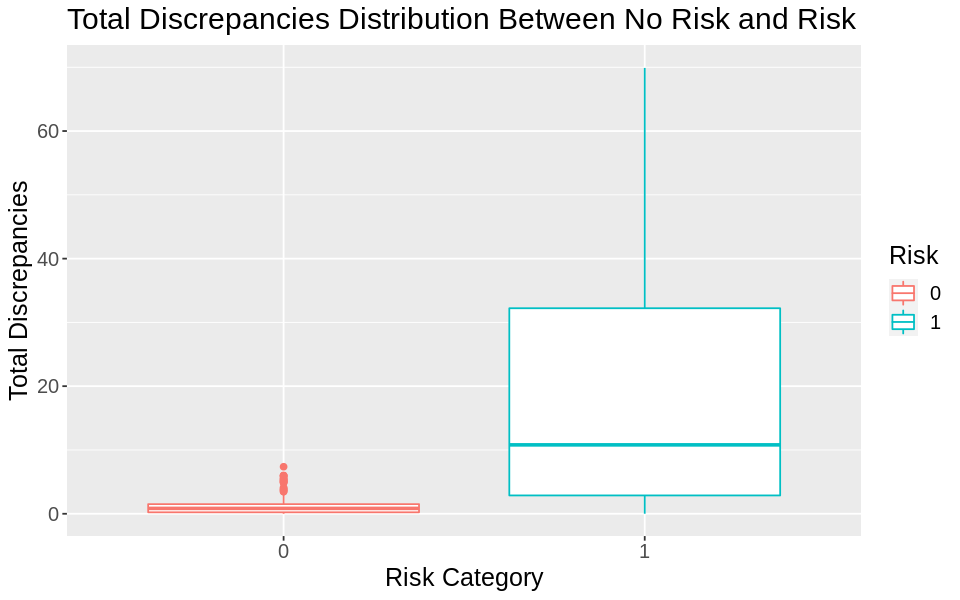

In [40]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(audit_training_select, aes(x = Risk, y=TOTAL, color = Risk)) +
  geom_boxplot() +
  ylim(c(0, 70)) +
  labs(x = "Risk Category", y = "Total Discrepancies") +
  ggtitle("Total Discrepancies Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))

Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”


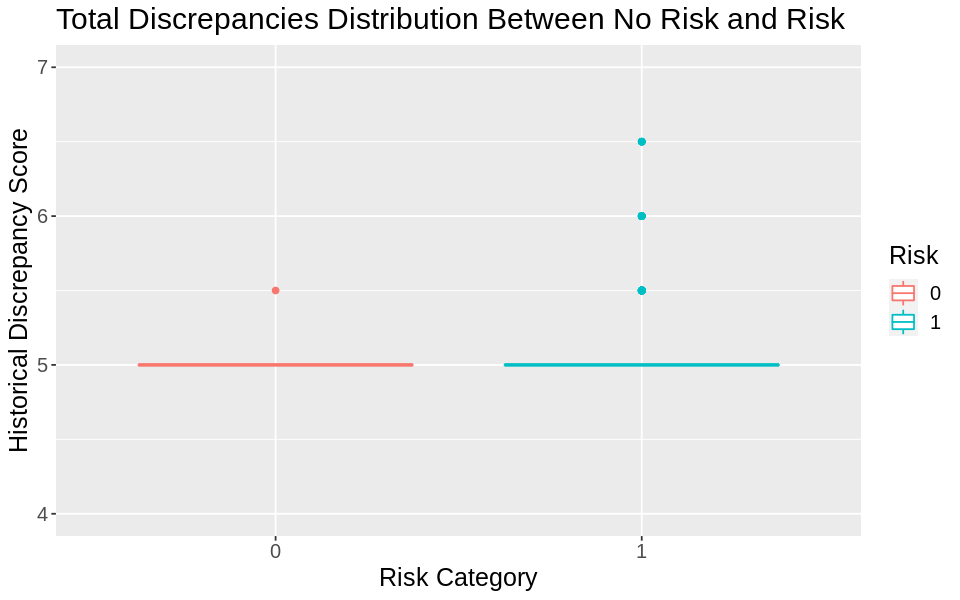

In [99]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(audit_training_select, aes(x = Risk, y=numbers, color = Risk)) +
  geom_boxplot() +
  ylim(c(4, 7)) +
  labs(x = "Risk Category", y = "Historical Discrepancy Score") +
  ggtitle("Total Discrepancies Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))

Warning message:
“Removed 13 rows containing non-finite values (stat_boxplot).”


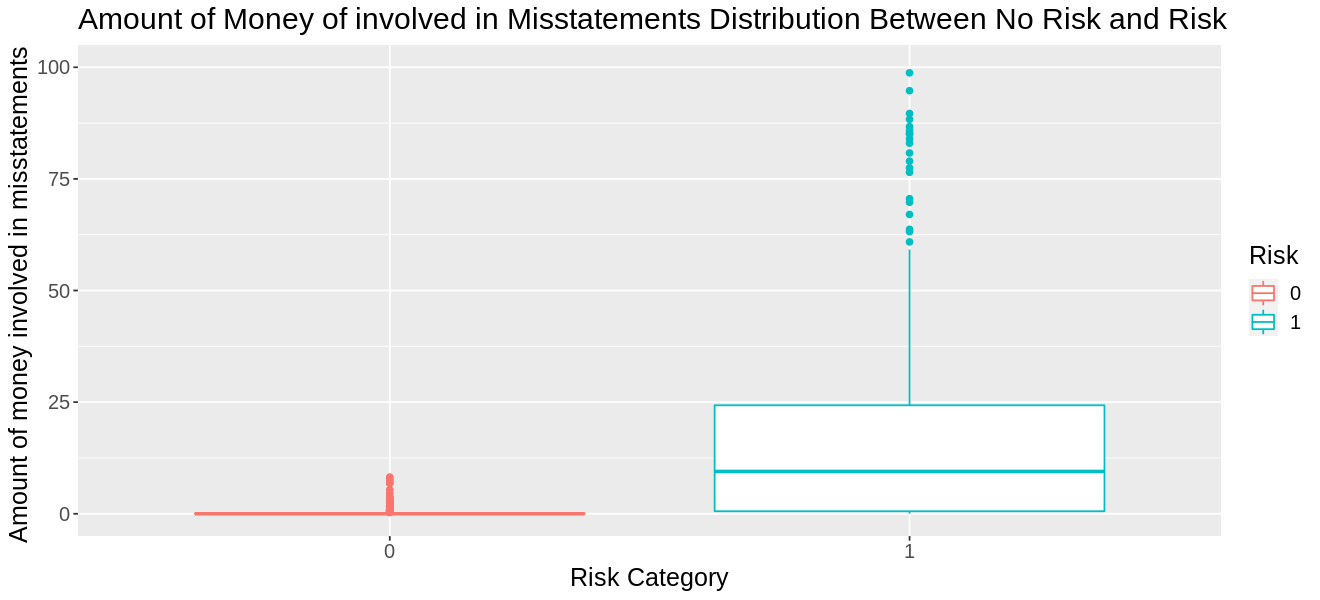

In [58]:
options(repr.plot.width = 11, repr.plot.height = 5)
ggplot(audit_training_select, aes(x = Risk, y=Money_Value, color = Risk)) +
  geom_boxplot() +
  ylim(c(0, 100)) +
  labs(x = "Risk Category", y = "Amount of money involved in misstatements ") +
  ggtitle("Amount of Money of involved in Misstatements Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))

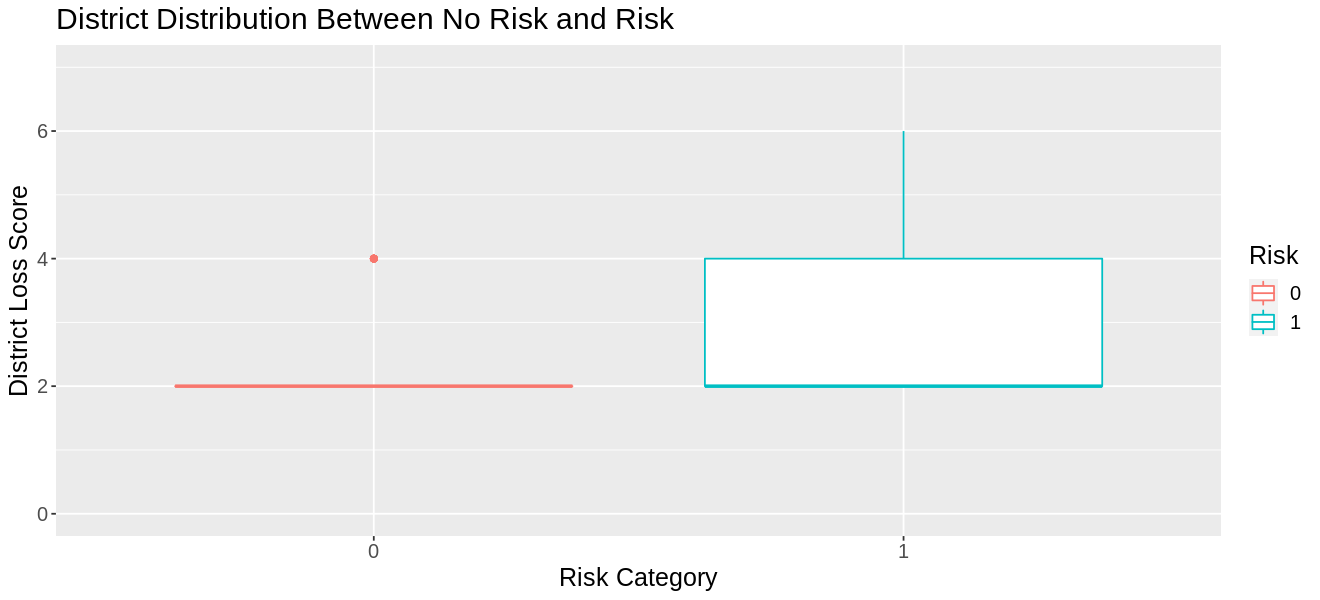

In [63]:
options(repr.plot.width = 11, repr.plot.height = 5)
ggplot(audit_training_select, aes(x = Risk, y=District_Loss, color = Risk)) +
  geom_boxplot() +
  ylim(c(0, 7)) +
  labs(x = "Risk Category", y = "District Loss Score") +
  ggtitle("District Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))

Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”


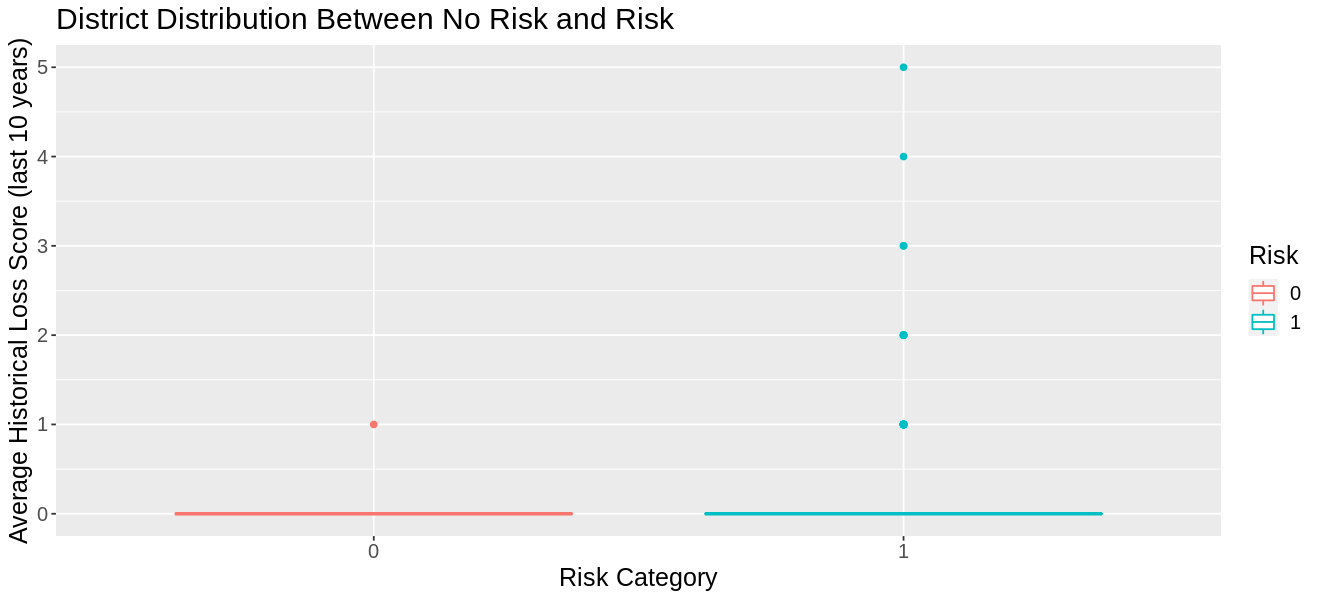

In [71]:
options(repr.plot.width = 11, repr.plot.height = 5)
ggplot(audit_training_select, aes(x = Risk, y=History, color = Risk)) +
  geom_boxplot() +
  ylim(c(0, 5)) +
  labs(x = "Risk Category", y = "Average Historical Loss Score (last 10 years)") +
  ggtitle("District Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))

Warning message:
“Removed 13 rows containing missing values (geom_point).”


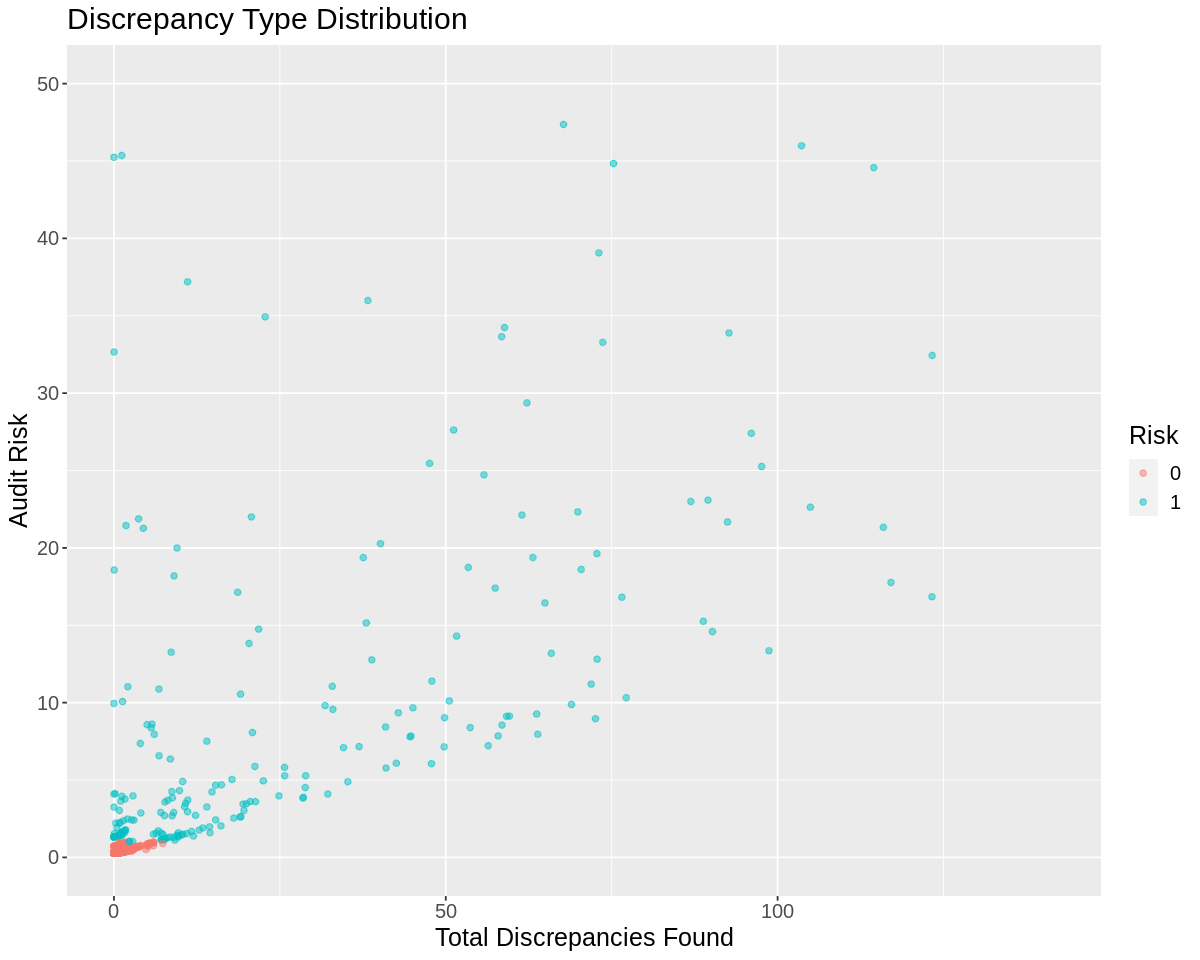

In [98]:
options(repr.plot.width = 10, repr.plot.height = 8)
discrepancy_plot <- audit_scaled_filter |>
ggplot(aes(x = TOTAL, y = Audit_Risk, color = Risk)) +
geom_point(alpha = 0.5) +
    xlab("Total Discrepancies Found") +
    ylab("Audit Risk") +
    labs(color = "Risk") +
    ggtitle("Discrepancy Type Distribution") +
    theme(text = element_text(size = 15))+
    ylim(c(0, 50))


discrepancy_plot

See if there is any clustering or relationship between Total Number of Discrepancies found and Audit Risk

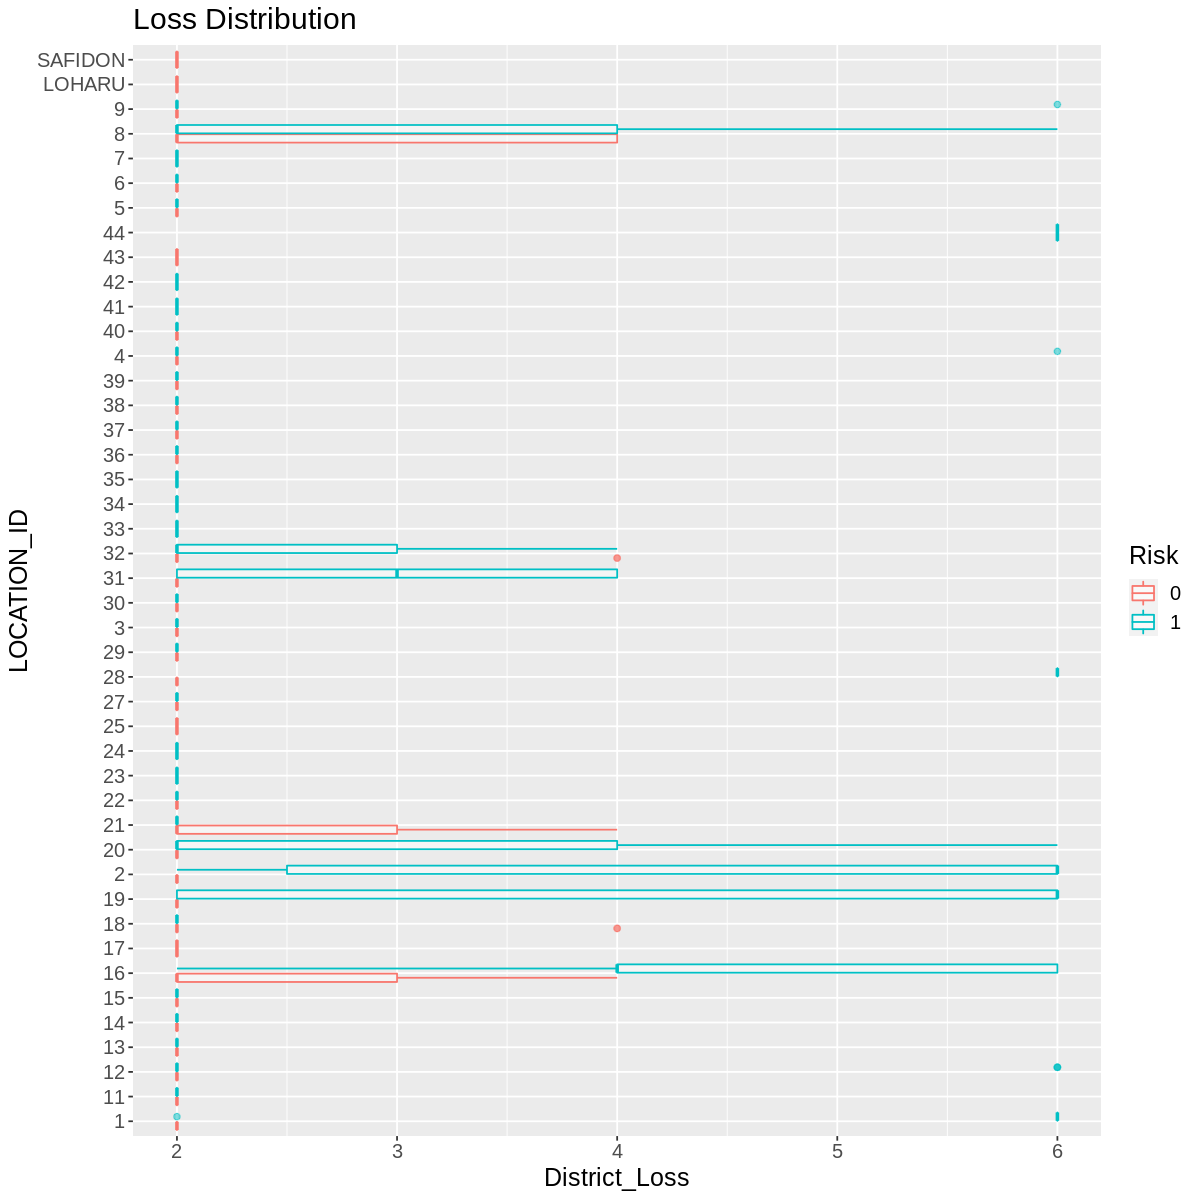

In [23]:
options(repr.plot.width = 10, repr.plot.height = 10)
district_loss_plot <- audit_scaled_filter |>
ggplot(aes(x = District_Loss, y = LOCATION_ID, color = Risk)) +
geom_boxplot(alpha = 0.5) +
    xlab("District_Loss") +
    ylab("LOCATION_ID") +
    labs(color = "Risk") +
    ggtitle("Loss Distribution") +
    theme(text = element_text(size = 15))

district_loss_plot

See which areas have the most losses